#License
    IPython notebook for simulating the heat equation with OpenCL
    Copyright (C) 2015 Andre.Brodtkorb@ifi.uio.no

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <http://www.gnu.org/licenses/>.

In [1]:
#Lets have matplotlib "inline"
%pylab inline

#Lets have opencl ipython integration enabled
%load_ext pyopencl.ipython_ext

#Import packages we need
import numpy as np
import pyopencl as cl

#Make sure we get compiler output from OpenCL
import os
os.environ["PYOPENCL_COMPILER_OUTPUT"] = "1"

Populating the interactive namespace from numpy and matplotlib


In [2]:
#Create OpenCL context
cl_ctx = cl.create_some_context()

#Create an OpenCL command queue
cl_queue = cl.CommandQueue(cl_ctx)

#Heat equation in 1D
The heat equation can be written
$$
\begin{align}
\frac{\partial u}{\partial t} &= \kappa \nabla^2 u\\
&= \kappa \frac{\partial^2 u}{\partial x^2}
\end{align}
$$
where $u$ is the temperature, and $\kappa$ is the material specific heat conduction constant. 

By approximating the temporal derivative with a backward difference, and the spatial derivative with a central difference, we get
$$
\frac{1}{\Delta t} (u_i^{n+1} - u_i^{n}) = \kappa \frac{1}{\Delta x^2}(u_{i-1}^n - 2u_i^n + u_{i+1}^n)
$$
and gathering $u^n+1$ on the left hand side and $u^n$on the right, we write
$$
u^{n+1}_i = u_i^n + \frac{\kappa\Delta t}{\Delta x^2}(u_{i-1}^n - 2u_i^n + u_{i+1}^n)
$$
This discretization is unstable if the following CFL condition is not met
$$
\frac{1}{2} \gt \frac{\kappa\Delta t}{\Delta x^2}
$$
or 
$$
\Delta t \lt \frac{\Delta x^2}{2\kappa}
$$

In [3]:
%%cl_kernel 
__kernel void heat_eq_1D(__global float *u1, __global const float *u0, float kappa, float dt, float dx) {
    int i = get_global_id(0); //Skip ghost cells
    int nx = get_global_size(0); //Get total number of cells

    //Internal cells
    if (i > 0 && i < nx-1) {
        u1[i] = u0[i] + kappa*dt/(dx*dx) * (u0[i-1] - 2*u0[i] + u0[i+1]);
    }
    //Boundary conditions (ghost cells)
    else { 
        u1[i] = u0[i];
    }
}

C:\Users\anbro\AppData\Local\Enthought\Canopy32\User\lib\site-packages\pyopencl\__init__.py:59: CompilerWarning: Built kernel retrieved from cache. Original from-source build had warnings:
Build on <pyopencl.Device 'Intel(R) Core(TM) i7-5600U CPU @ 2.60GHz' on 'Intel(R) OpenCL' at 0x6bb558> succeeded, but said:

Compilation started
Compilation done
Linking started
Linking done
Device build started
Device build done
Kernel <heat_eq_1D> was successfully vectorized
Done.
  warn(text, CompilerWarning)
C:\Users\anbro\AppData\Local\Enthought\Canopy32\User\lib\site-packages\pyopencl\__init__.py:59: CompilerWarning: From-binary build succeeded, but resulted in non-empty logs:
Build on <pyopencl.Device 'Intel(R) Core(TM) i7-5600U CPU @ 2.60GHz' on 'Intel(R) OpenCL' at 0x6bb558> succeeded, but said:

Linking started
Linking done
Device build started
Device build done
Kernel <heat_eq_1D> was successfully vectorized
Done.
  warn(text, CompilerWarning)


In [4]:
"""
Class that holds data for the heat equation in OpenCL
"""
class HeatDataCL:
    """
    Uploads initial data to the CL device
    """
    def __init__(self, u0):
        #Make sure that the data is single precision floating point
        assert(np.issubdtype(u0.dtype, np.float32))
        
        #Find number of cells
        self.nx = len(u0)
        
        mf = cl.mem_flags 
        
        #Upload data to the device
        self.u0 = cl.Buffer(cl_ctx, mf.READ_WRITE | mf.COPY_HOST_PTR, hostbuf=u0)
        
        #Allocate output buffers
        self.u1 = cl.Buffer(cl_ctx, mf.READ_WRITE, u0.nbytes)
        
    """
    Enables downloading data from CL device to Python
    """
    def download(self):
        #Allocate data on the host for result
        u0 = np.empty(self.nx, dtype=np.float32)
        
        #Copy data from device to host
        cl.enqueue_copy(cl_queue, u0, self.u0)
        
        #Return
        return u0;

In [5]:
"""
Computes the heat equation using an explicit finite difference scheme with OpenCL
"""
def opencl_heat_eq(cl_data, kappa, dx, nt):
    #Calculate dt from the CFL condition
    dt = 0.8 * dx*dx / (2.0*kappa)

    #Loop through all the timesteps
    for i in range(nt):
        #Execute program on device
        heat_eq_1D(cl_queue, (cl_data.nx,1), None, cl_data.u1, cl_data.u0, numpy.float32(kappa), numpy.float32(dt), numpy.float32(dx))
        
        #Swap variables
        cl_data.u0, cl_data.u1 = cl_data.u1, cl_data.u0

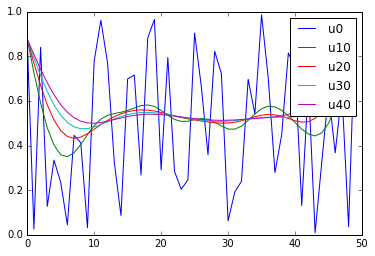

In [6]:
#Create test input data
u0 = np.random.rand(50).astype(np.float32)
cl_data = HeatDataCL(u0)
kappa = 1.0
dx = 1.0

#Plot initial conditions
figure()
plot(u0, label="u0")

for i in range(1, 5):
    timesteps_per_plot=10
    #Simulate 10 timesteps
    opencl_heat_eq(cl_data, kappa, dx, timesteps_per_plot)

    #Download data
    u1 = cl_data.download()

    #Plot
    plot(u1, label="u"+str(timesteps_per_plot*i))
    
legend()